In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

In [2]:
# ## Load raw Z+X events
# import pickle
# with open("/data/pku/home/licq/cH/zz_v2/external-tools/HZZAnalysis/ZZ4lAna/ZplusX/results.pkl", "rb") as f:
#     results = pickle.load(f)

In [2]:
# df = uproot.lazy("/home/pku/licq/cH/zz_v2/samples/zzntuples/Data_UL18/data_ul18_all.root:Ana/passedEvents")

In [2]:
from importlib import reload
import cutflow
inner_dim_indexing = reload(cutflow).inner_dim_indexing

In [3]:
def cal_mass4l(df, results):

    _lep_unselected = ak.zip(dict(
        pt=df.lep_pt[results['i']],
        eta=df.lep_eta[results['i']],
        phi=df.lep_phi[results['i']],
        mass=df.lep_mass[results['i']],
        id=df.lep_id[results['i']],
        ),
    )
    _lep = {}
    for b in ak.fields(_lep_unselected):
        _lep[b] = inner_dim_indexing(ak.values_astype(_lep_unselected[b], np.float32), ak.Array(results['lep_CRindex']), ak.ArrayBuilder()).snapshot()
    _lep = ak.zip(_lep)

    _lep_lo = ak.zip(
        dict(
            pt=_lep.pt,
            eta=_lep.eta,
            phi=_lep.phi,
            mass=_lep.mass,
            id=_lep.id,
        ),
        behavior=vector.behavior,
        with_name='PtEtaPhiMLorentzVector',
    )
    zz_lo = _lep_lo[:, 0] + _lep_lo[:, 1] + _lep_lo[:, 2] + _lep_lo[:, 3]
    return zz_lo.mass

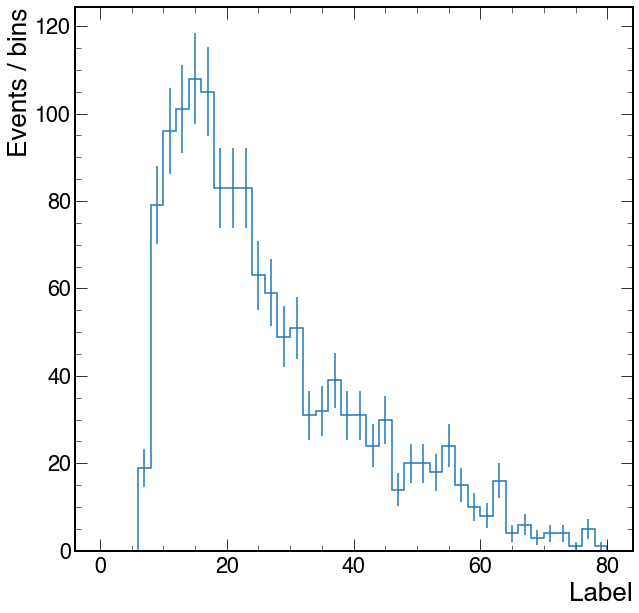

In [19]:
# import boost_histogram as bh
# import mplhep as hep
# import matplotlib.pyplot as plt
# plt.style.use(hep.style.ROOT)

# f, ax = plt.subplots(figsize=(10,10))

# nbin, xmin, xmax = 40, 0, 80
# hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

# hist.fill(_lep_lo[:, 2].pt[(abs(_lep_lo[:, 2].id)==11) & (abs(_lep_lo[:, 0].id)==11) ])

# content, yerr = hist.view().value, np.sqrt(hist.view().variance)
# hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
# ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);

In [8]:
file_wgt_dict = {
    "crab_EGamma_Run18A": 1.0373,
    "crab_EGamma_Run18B": 1.0373,
    "crab_EGamma_Run18C": 1.0373,
    "crab_EGamma_Run18D": 1.0373,
    "crab_MuonEG_Run18A": 1.0023,
    "crab_MuonEG_Run18B": 1.0023,
    "crab_MuonEG_Run18C": 1.0023,
    "crab_MuonEG_Run18D": 1.0023,
    "crab_SingleMuon_Run18A": 1.1575,
    "crab_SingleMuon_Run18C": 1.1575,
    "crab_SingleMuon_Run18D": 1.1575,
    "crab_DoubleMuon_Run18A": 1.0034,
    "crab_DoubleMuon_Run18B": 1.0034,
    "crab_DoubleMuon_Run18C": 1.0034,
    "crab_DoubleMuon_Run18D": 1.0034,
}
    
loaded_branches = [
    'Run', 'Event', 'LumiSect', 'genWeight', 'D_bkg_kin',
    'lep_pt', 'lep_eta', 'lep_phi', 'lep_mass', 'lep_id', 'lep_RelIso', 'lep_tightId', 'lep_RelIsoNoFSR', #lep_Hindex
    'fsrPhotons_pt', 'fsrPhotons_eta', 'fsrPhotons_phi', 'fsrPhotons_lepindex',
    'sv_pt', 'sv_eta', 'sv_phi', 'sv_mass', 'sv_costhetasvpv', 'sv_ParticleNet_b', 'sv_ParticleNet_bb', 'sv_ParticleNet_c', 'sv_ParticleNet_cc', 'sv_ParticleNet_unmat',
    'jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_DeepJet_CvsL', 'jet_DeepJet_CvsB', 'jet_ParticleNet_b', 'jet_ParticleNet_bb', 'jet_ParticleNet_c', 'jet_ParticleNet_cc',
    'jet_ParticleNet_uds', 'jet_ParticleNet_g', 'jet_ParticleNet_undef', 'jet_ParticleNet_pu', 'jet_ParticleNet_CvsL', 'jet_ParticleNet_CvsB', 'jet_hadronFlavour', 'jet_iscleanH4l',
]

global_output = {}
def fill_global_output(output):
    global global_output
    for k, v in output.items():
        if k not in global_output:
            global_output[k] = []
        global_output[k].append(v)

for file in list(file_wgt_dict.keys()):

    print(file)
    df = uproot.lazy(f"/home/pku/licq/cH/zz_v2/samples/zzntuples/Data_UL18_2lep/{file}.root:Ana/passedEvents")

    import pickle
    with open(f"/data/pku/home/licq/cH/zz_v2/external-tools/HZZAnalysis/ZZ4lAna/ZplusX/ZX_{file}.root.pkl", "rb") as f:
        results = pickle.load(f)

    output = {}
    for b in loaded_branches:
        print('  loading .. ', b)
        output[b] = df[b][results['i']]

    output['mass4l'] = ak.Array(cal_mass4l(df, results))
    output['lep_Hindex'] = ak.Array(results['lep_CRindex']) # rewrite lep_Hindex
    output['ZXWeight'] = ak.Array(results['ZXWeight'])
    output['ZXFileWeight'] = ak.ones_like(output['ZXWeight']) * file_wgt_dict[file]

    fill_global_output(output)

# with uproot.recreate("coffea_output/ZX.root") as fw:
#     fw['Ana/passedEvents'] = output

crab_EGamma_Run18A
  loading ..  Run
  loading ..  Event
  loading ..  LumiSect
  loading ..  genWeight
  loading ..  D_bkg_kin
  loading ..  lep_pt
  loading ..  lep_eta
  loading ..  lep_phi
  loading ..  lep_mass
  loading ..  lep_id
  loading ..  lep_RelIso
  loading ..  lep_tightId
  loading ..  lep_RelIsoNoFSR
  loading ..  fsrPhotons_pt
  loading ..  fsrPhotons_eta
  loading ..  fsrPhotons_phi
  loading ..  fsrPhotons_lepindex
  loading ..  sv_pt
  loading ..  sv_eta
  loading ..  sv_phi
  loading ..  sv_mass
  loading ..  sv_costhetasvpv
  loading ..  sv_ParticleNet_b
  loading ..  sv_ParticleNet_bb
  loading ..  sv_ParticleNet_c
  loading ..  sv_ParticleNet_cc
  loading ..  sv_ParticleNet_unmat
  loading ..  jet_pt
  loading ..  jet_eta
  loading ..  jet_phi
  loading ..  jet_mass
  loading ..  jet_DeepJet_CvsL
  loading ..  jet_DeepJet_CvsB
  loading ..  jet_ParticleNet_b
  loading ..  jet_ParticleNet_bb
  loading ..  jet_ParticleNet_c
  loading ..  jet_ParticleNet_cc
  loadi

In [9]:
global_output_merged = {}
for k, v in global_output.items():
    global_output_merged[k] = ak.concatenate(v)

with uproot.recreate("coffea_output/ZX_1.root") as fw:
    fw['Ana/passedEvents'] = global_output_merged